### Importing Libraries

In [2]:
# Import Libraries

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import Augmentor
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

### Enable mixed precision training for faster execution

In [4]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")
tf.config.optimizer.set_jit(True)  # Enable XLA optimization

In [5]:
class PyDataset(tf.keras.utils.Sequence):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)  

In [6]:
# Loading training and test datasets

train_dir = "Skin cancer ISIC The International Skin Imaging Collaboration/Train"
test_dir = "Skin cancer ISIC The International Skin Imaging Collaboration/Test"

### Create Train & Validation Datasets

In [8]:
img_size = (180, 180)
batch_size = 32

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,  # Increased from 30
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.8,1.2],  # Added brightness adjustment
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 5395 images belonging to 9 classes.
Found 1344 images belonging to 9 classes.


### Data Visualization

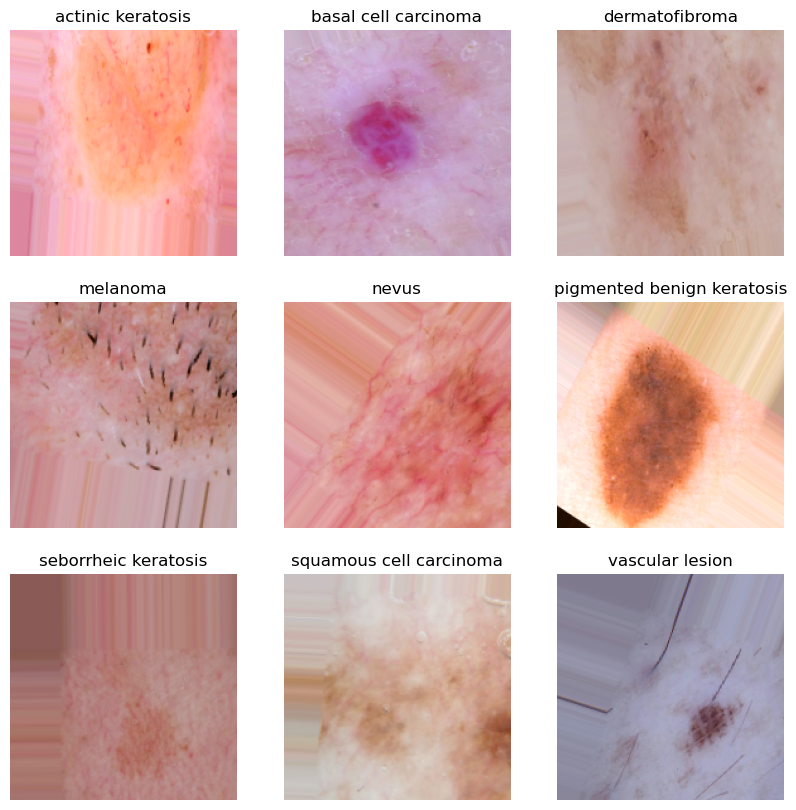

In [10]:
def visualize_sample_images(generator):
    class_labels = list(generator.class_indices.keys())  # Get class names
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))

    for ax, label in zip(axes.flat, class_labels):
        img, _ = next(generator)  # Use `next(generator)` instead of `generator.next()`
        ax.imshow(img[0])  # Display the first image from the batch
        ax.set_title(label)
        ax.axis('off')
    
    plt.show()

# Call the function with your train_generator
visualize_sample_images(train_generator)

### Class Distribution Analysis

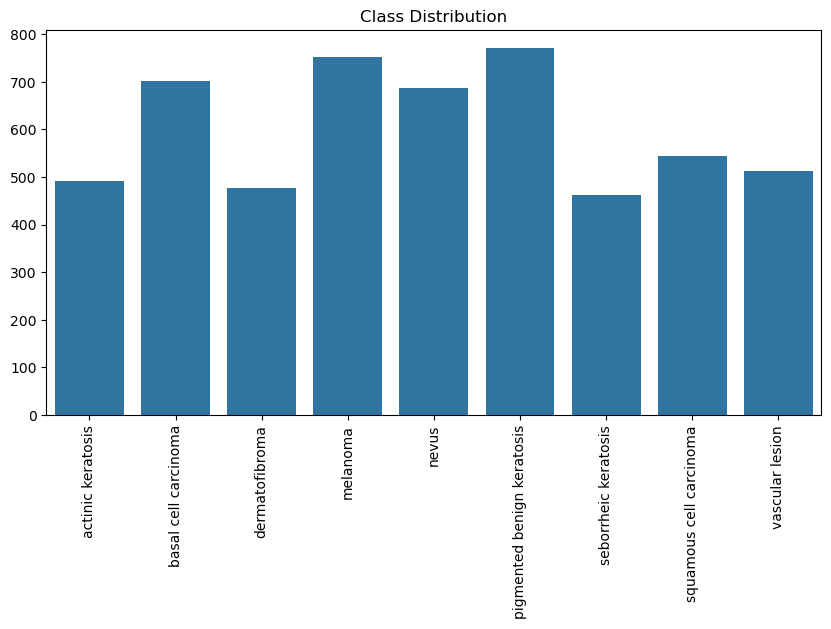

In [12]:
labels = train_generator.classes
class_counts = Counter(labels)
plt.figure(figsize=(10,5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(range(len(train_generator.class_indices)), list(train_generator.class_indices.keys()), rotation=90)
plt.title("Class Distribution")
plt.show()

### Handling Class Imbalance with Augmentor

In [14]:
for class_name in train_generator.class_indices.keys():
    p = Augmentor.Pipeline(os.path.join(train_dir, class_name))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.flip_left_right(probability=0.5)
    p.sample(500)  # Adjust based on imbalance

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x161229F10>: 100%|██████████| 500/500 [00:01<00:00, 366.90 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x164EF23C0>: 100%|██████████| 500/500 [00:01<00:00, 393.75 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x164E00200>: 100%|██████████| 500/500 [00:01<00:00, 353.73 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x157B197C0>: 100%|██████████| 500/500 [00:06<00:00, 76.61 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x160D39880>: 100%|██████████| 500/500 [00:06<00:00, 82.53 Samples/s]                     


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x161229DF0>: 100%|██████████| 500/500 [00:01<00:00, 348.91 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x164D4A660>: 100%|██████████| 500/500 [00:02<00:00, 168.52 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1612EF8C0>: 100%|██████████| 500/500 [00:01<00:00, 343.67 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1612EE7E0>: 100%|██████████| 500/500 [00:01<00:00, 337.39 Samples/s]                  


In [15]:
# Reload Data after Augmentation
train_balanced = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

Found 8995 images belonging to 9 classes.


### Define Optimized CNN Model

In [17]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(180, 180, 3)),
        tf.keras.layers.BatchNormalization(),  # Normalize activations
        tf.keras.layers.MaxPooling2D((2,2)),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),

        tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),

        tf.keras.layers.Conv2D(256, (3,3), activation='relu'),  # Added more filters
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2,2)),

        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),  # Increased neuron count
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(9, activation='softmax')
    ])
    return model

model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)  # Was 0.0005
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

### Early Stopping & Model Checkpoint

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint("cnn_best_model.keras", save_best_only=True, monitor="val_loss", mode="min")


### Train Model with Class Weights

In [23]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

history = model.fit(
    train_balanced,
    epochs=30,
    validation_data=val_generator
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 128s 451ms/step - accuracy: 0.2776 - loss: 2.2026 - val_accuracy: 0.1317 - val_loss: 2.6188
Epoch 2/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 128s 452ms/step - accuracy: 0.3635 - loss: 1.7151 - val_accuracy: 0.3981 - val_loss: 1.5513
Epoch 3/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 128s 451ms/step - accuracy: 0.3891 - loss: 1.6238 - val_accuracy: 0.3914 - val_loss: 1.5859
Epoch 4/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 129s 457ms/step - accuracy: 0.4024 - loss: 1.5603 - val_accuracy: 0.3140 - val_loss: 1.7558
Epoch 5/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 131s 463ms/step - accuracy: 0.4125 - loss: 1.5290 - val_accuracy: 0.3936 - val_loss: 1.5848
Epoch 6/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 128s 454ms/step - accuracy: 0.4373 - loss: 1.4980 - val_accuracy: 0.3787 - val_loss: 1.7251
Epoch 7/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 125s 443ms/step - accuracy: 0.4425 - loss: 1.4761 - val_accuracy: 0.3690 - val_loss: 1.7583
Epoch 8/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 125s 442ms/step - accuracy: 0.4432 -

### Plot Training History

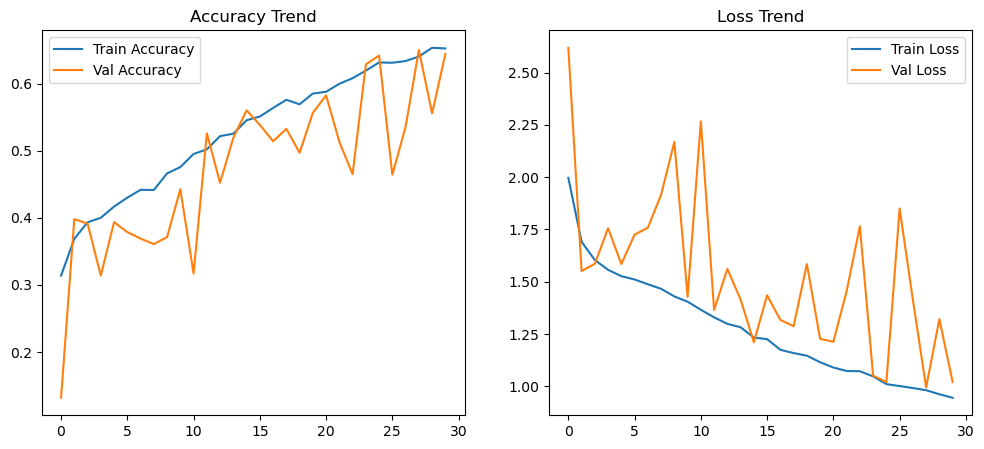

In [25]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy Trend')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss Trend')
    plt.show()

plot_training_history(history)

In [27]:
#Save Final Model
model.save("melanoma_cnn_model_optimized.keras")